In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aydafrough","key":"6f11d390d25b1f8e7987d65c72badb9a"}'}

In [4]:
! mkdir ~/.kaggle


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                         title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           5401        188  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Prediction Dataset    5MB  2023-07-03 12:12:19           6453        248  1.0              
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                          25KB  2023-07-04 07:38:41           6647        130  1.0              
joebeachcapital/top-10000-spotify-songs-1960-now            Top 10000 Songs on Spotify 1960-Now

In [8]:
!kaggle competitions download -c 'Food-11 image dataset'

403 - Forbidden - Permission 'competitions.participate' was denied


In [9]:
!kaggle datasets download -d trolukovich/food11-image-dataset

100% 1.08G/1.08G [00:11<00:00, 102MB/s]
100% 1.08G/1.08G [00:11<00:00, 102MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('food11-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
import torch
import torchvision
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt

In [12]:

train_path = Path('training')
validation_path = Path('validation')
evaluation_path = Path('evaluation')

In [13]:
#get the device
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

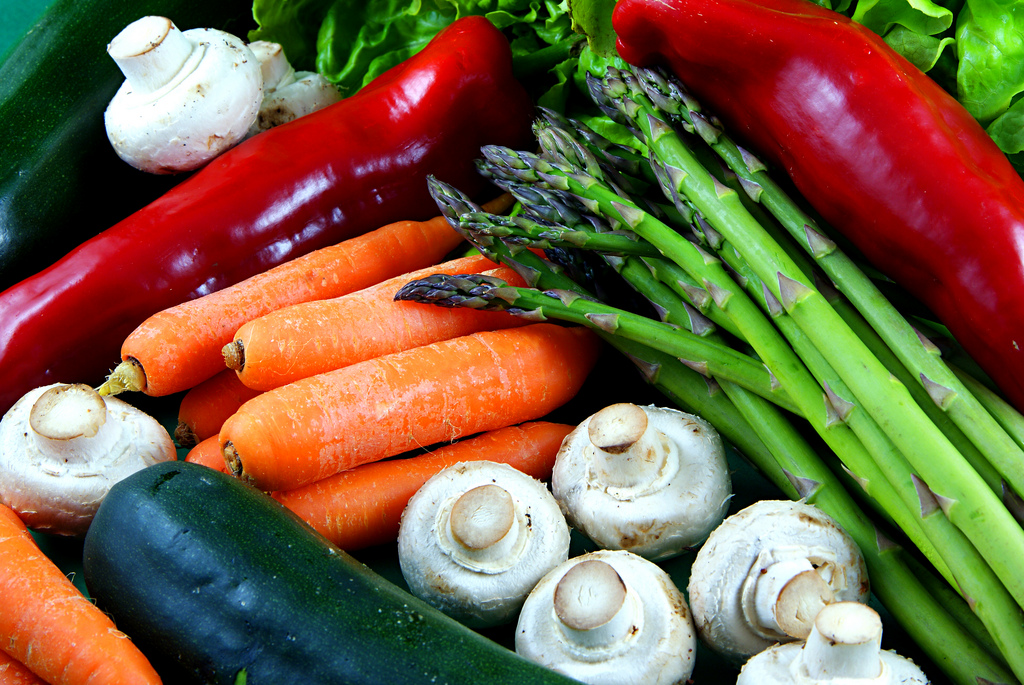

In [14]:
#open a random image to assess data
from PIL import Image
import random
image_path_list= list(validation_path.glob("*/*.jpg"))
image_path=random.choice(image_path_list)
img=Image.open(image_path)
img


In [15]:
#get the class of image using stem
image_classes=image_path.parent.stem
print(image_classes)

Vegetable-Fruit


In [16]:
#find out the shape of images
img_as_array=np.asarray(img)
img_as_array.shape

(685, 1024, 3)

In [17]:
#set transform
normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
data_transform=transforms.Compose([transforms.Resize(size=(224,224)),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.ToTensor(),
                                  normalize])

In [18]:
#create datasets useing ImageFolder
from torchvision import datasets
train_data=datasets.ImageFolder(root=train_path,
                                transform=data_transform,
                                target_transform=None)
test_data=datasets.ImageFolder(root=validation_path,
                               transform=data_transform )

In [19]:
class_names=test_data.classes
class_names

['Bread',
 'Dairy product',
 'Dessert',
 'Egg',
 'Fried food',
 'Meat',
 'Noodles-Pasta',
 'Rice',
 'Seafood',
 'Soup',
 'Vegetable-Fruit']

In [20]:
len(train_data), len(test_data)

(9866, 3430)

In [21]:
# create dataloaders
import os
batch_size=32
train_dataloader=DataLoader(dataset=train_data,
                           batch_size=batch_size,
                            num_workers=os.cpu_count(),
                           shuffle=True)
test_dataloader=DataLoader(dataset=test_data,
                          batch_size=batch_size,
                           num_workers=os.cpu_count(),
                          shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f93bf9bddb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f93bf9bc130>)

In [22]:
#get our pretrained model

weights=torchvision.models.ResNet50_Weights.DEFAULT
model=torchvision.models.resnet50(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
#tochinfo
!pip install torchinfo


In [24]:
#summary
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [25]:
#freeze
for param in model.parameters():

  param.requires_grad=False

In [26]:
# accuracy
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 10.9 MB/s eta 0:00:00


In [27]:
model.fc=nn.Linear(in_features=2048, out_features=len(class_names), bias=True).to(device)



In [28]:
#summary
from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),#batch size, color channels height, width
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 11]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [29]:
from torchmetrics import Accuracy

In [30]:
#loss and optimizer , accuracy
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.001)
accuracy=Accuracy(task="multiclass",num_classes=11).to(device)

In [31]:
#train step

epochs=10
train_loss,train_acc=0,0
test_loss, test_acc=0,0
results={"train_loss":[],
         "train_acc":[],
         "test_loss":[],
         "test_acc":[],
         "eval_loss":[],
         "eval_acc":[]}
for epoch in range(epochs):

  for batch,(x,y) in enumerate(train_dataloader):
    x,y=x.to(device), y.to(device)
    train_pred=model(x)

    loss=loss_fn(train_pred,y)
    train_loss +=loss.item()
    acc=accuracy(torch.argmax(torch.softmax(train_pred,dim=1),dim=1),y)
    train_acc +=acc.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss =train_loss/ len(train_dataloader)
  train_acc =train_acc/ len(train_dataloader)
  results["train_loss"].append(train_loss)
  results["train_acc"].append(train_acc)



  print(f"epoch: {epoch}, train_loss:{train_loss}, train_accuracy: {train_acc}  ")





epoch: 0, train_loss:2.2765768453912827, train_accuracy: 0.2623179611843381  
epoch: 1, train_loss:2.1027829468589245, train_accuracy: 0.3642186665410496  
epoch: 2, train_loss:1.9721655706179892, train_accuracy: 0.4160654325392236  
epoch: 3, train_loss:1.869468630279542, train_accuracy: 0.4691053897541403  
epoch: 4, train_loss:1.7801608254252559, train_accuracy: 0.516890308704706  
epoch: 5, train_loss:1.7032607116133838, train_accuracy: 0.5554955997817042  
epoch: 6, train_loss:1.6330887285372686, train_accuracy: 0.5817936750801996  
epoch: 7, train_loss:1.5731291617285925, train_accuracy: 0.6143019213171558  
epoch: 8, train_loss:1.5127201994148698, train_accuracy: 0.6310131130332609  
epoch: 9, train_loss:1.46353665862908, train_accuracy: 0.6426367739057447  


In [32]:
for epoch in range(epochs):
  #test step
  model.eval()
  with torch.inference_mode():
    for batch,(x,y) in enumerate(test_dataloader):
      x,y=x.to(device), y.to(device)
      test_pred=model(x)

      loss=loss_fn(test_pred,y)
      test_loss +=loss.item()
      acc=accuracy(torch.argmax(torch.softmax(test_pred,dim=1),dim=1),y)
      test_acc +=acc.item()

  test_loss =test_loss/ len(test_dataloader)
  test_acc =test_acc/ len(test_dataloader)
  results["test_loss"].append(test_loss)
  results["test_acc"].append(test_acc)
  print(f"test_loss:{test_loss}, test_accuracy: {test_acc}")

test_loss:1.4448982880071357, test_accuracy: 0.6651234566061585
test_loss:1.4591279246056115, test_accuracy: 0.6711855568809355
test_loss:1.4599809979745304, test_accuracy: 0.6683481689205168
test_loss:1.4572345962452193, test_accuracy: 0.6701544581702373
test_loss:1.4605842666404547, test_accuracy: 0.6710392386262533
test_loss:1.4574020806990446, test_accuracy: 0.673072894000846
test_loss:1.4572335365782938, test_accuracy: 0.6728023722913515
test_loss:1.4577079993738167, test_accuracy: 0.66894184313728
test_loss:1.4571385893945463, test_accuracy: 0.6707386588574296
test_loss:1.4579054624152448, test_accuracy: 0.6723949569017806


In [33]:
#evaluate model

#prepare data
eval_data=torchvision.datasets.ImageFolder(root=evaluation_path,
                                            transform=data_transform)

eval_dataloader=DataLoader(dataset=eval_data,
                           batch_size=batch_size,
                           num_workers=os.cpu_count())


#evaluate
eval_loss,eval_acc=0,0
model.eval()
with torch.inference_mode():
  for epoch in range(epochs):
    for batch,(x,y)  in enumerate(eval_dataloader):
      x,y=x.to(device), y.to(device)

      eval_pred=model(x)

      loss=loss_fn(torch.softmax(eval_pred,dim=1),y)
      eval_loss +=loss.item()

      acc=accuracy(torch.argmax(torch.softmax(eval_pred,dim=1),dim=1),y)
      eval_acc +=acc.item()

    eval_loss =eval_loss / len(eval_dataloader)
    eval_acc=eval_acc /len(eval_dataloader)
    results["eval_loss"].append(eval_loss)
    results["eval_acc"].append(eval_acc)


    print(f"epoch :{epoch}, evaluation loss:{eval_loss}, evaluation accuracy: {eval_acc}")







epoch :0, evaluation loss:2.1970320542653403, evaluation accuracy: 0.6849937342462086
epoch :1, evaluation loss:2.2179033695705352, evaluation accuracy: 0.700837659743908
epoch :2, evaluation loss:2.218193068900797, evaluation accuracy: 0.6932504590343623
epoch :3, evaluation loss:2.2183105277144635, evaluation accuracy: 0.6950735635378921
epoch :4, evaluation loss:2.2184935790462377, evaluation accuracy: 0.6923027057371621
epoch :5, evaluation loss:2.218558453361348, evaluation accuracy: 0.6973358404247743
epoch :6, evaluation loss:2.218585155339848, evaluation accuracy: 0.6943135993931111
epoch :7, evaluation loss:2.2178744658774026, evaluation accuracy: 0.6970573727453071
epoch :8, evaluation loss:2.2180343622110628, evaluation accuracy: 0.6876536790001623
epoch :9, evaluation loss:2.218101478525705, evaluation accuracy: 0.692138054998591


In [34]:
from typing import Dict,List
def plot_loss_curves(results:Dict[str, List[float]]):
  #plot training curves of a results dictionary
  #get the loss values of teh results dictionary(train, test)

  loss=results["train_loss"]
  test_loss =results["test_loss"]

  #get the accuracy of the results dictionary
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  #figure out how many epochs there were
  epochs= range(len(results["train_loss"]))

  # set up plot
  plt.figure(figsize=(7,7))
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot the accuracy
  """
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("Epochs")
  plt.legend()
  """

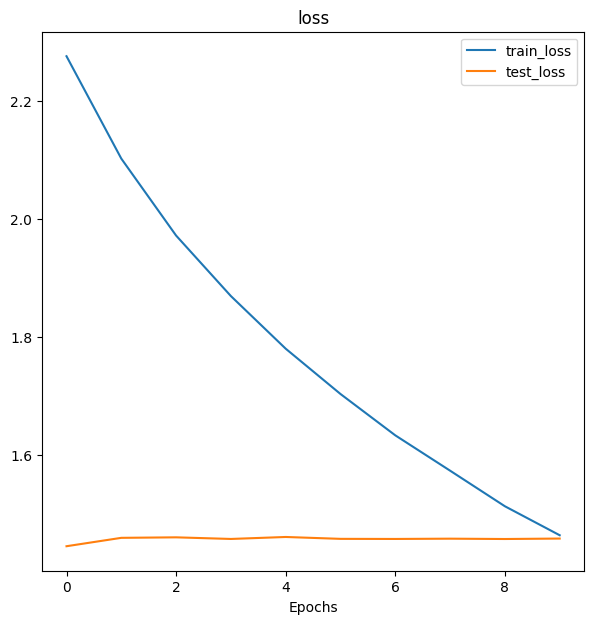

In [35]:
plot_loss_curves(results)